In [3]:
import utils.predictor_functions as pf
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete
Setup Complete


In [4]:
league = 'mls'
seasons = '2018-2024'
season_test = 2022
betting_starts_after_n_games = 50

In [5]:
# Read the data
X_full, y, X_test_full, y_test, odds_test = pf.get_league_data(league, seasons, season_test)
display(X_full)

,game_date,season,home_team,away_team,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2018-05-19,2018,Philadelphia,Real Salt Lake,36.666667,30.000000,20.000000,50.000000,40.000000,40.000000,...,0.000000,20.000000,80.000000,40.0,0.0,60.0,602.6,8046.4,1.70,2.46
1,2018-05-19,2018,New England,Columbus Crew,56.666667,50.000000,20.000000,30.000000,66.666667,16.666667,...,20.000000,40.000000,40.000000,60.0,40.0,0.0,4402.6,4200.0,1.92,0.82
2,2018-05-20,2018,Minnesota Utd,Sporting KC,36.363636,36.363636,0.000000,63.636364,60.000000,0.000000,...,60.000000,20.000000,20.000000,60.0,20.0,20.0,5202.4,4020.0,2.62,1.06
3,2018-05-26,2018,NY Red Bulls,Philadelphia,70.000000,70.000000,0.000000,30.000000,80.000000,0.000000,...,20.000000,0.000000,80.000000,60.0,0.0,40.0,6004.8,4620.2,1.30,1.10
4,2018-05-25,2018,Dynamo,NYCFC,50.000000,40.000000,30.000000,30.000000,60.000000,0.000000,...,28.571429,42.857143,28.571429,40.0,20.0,40.0,604.8,6284.0,1.90,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2021-11-07,2021,CF Montréal,Orlando City,46.464646,36.363636,30.303030,33.333333,56.250000,25.000000,...,25.000000,31.250000,43.750000,20.0,60.0,20.0,1.4,1.4,1.44,1.04
928,2021-11-07,2021,NYCFC,Philadelphia,50.505051,42.424242,24.242424,33.333333,62.500000,18.750000,...,18.750000,50.000000,31.250000,40.0,40.0,20.0,1.8,1.4,1.80,0.88
929,2021-11-07,2021,Toronto FC,D.C. United,28.282828,18.181818,30.303030,51.515152,25.000000,43.750000,...,12.500000,25.000000,62.500000,20.0,20.0,60.0,0.8,2.4,1.14,2.04
930,2021-11-07,2021,Colorado Rapids,Los Angeles FC,58.585859,48.484848,30.303030,21.212121,50.000000,43.750000,...,25.000000,18.750000,56.250000,60.0,40.0,0.0,2.2,1.0,1.88,1.82


In [6]:
# Define categorical and numerical columns
categorical_cols, numerical_cols = pf.set_numerical_categorical_cols(X_full)

# Keep selected columns only
X_train, y_train, X_test = pf.filter_datasets(X_full, y, X_test_full, categorical_cols, numerical_cols)

In [7]:
# hf.plot_feature_corr_chart(X_train, numerical_cols)

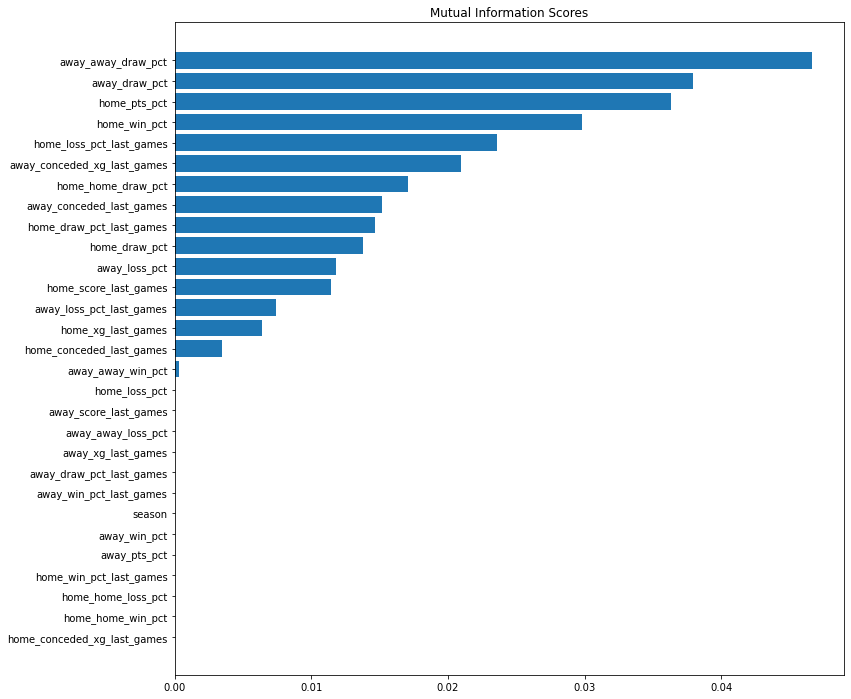

In [8]:
first_mi_scores = pf.make_mi_scores(X_train, y_train)
pf.plot_mi_scores(first_mi_scores)

In [9]:
X_train, X_test, kmeans_scaler_list, features_kmeans_list = pf.create_cluster_features(X_train, X_test, first_mi_scores)

Total features to consider when clustering: 29


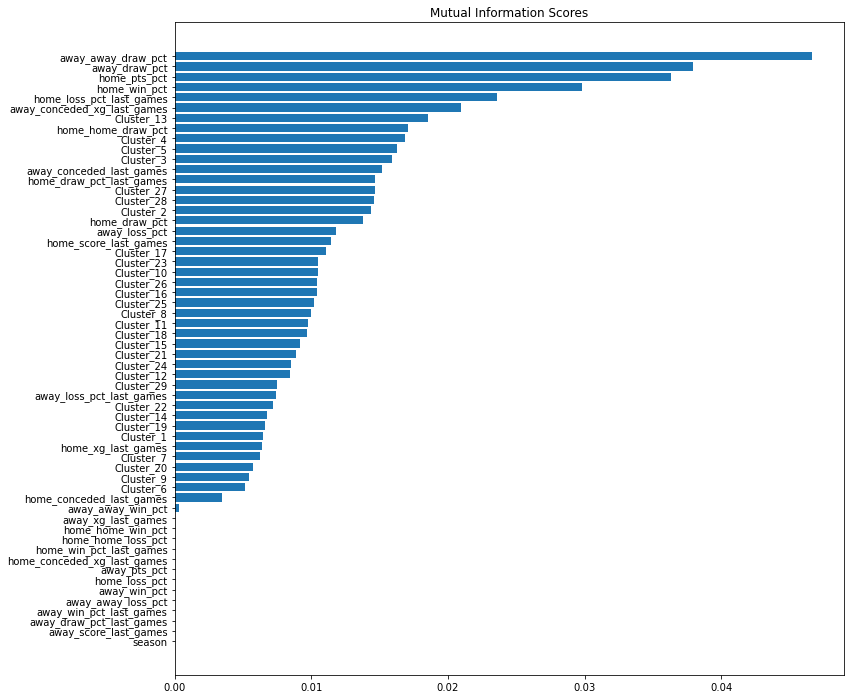

In [10]:
second_mi_scores = pf.make_mi_scores(X_train, y_train)
pf.plot_mi_scores(second_mi_scores)

In [11]:
X_train, X_test, pca_features, pca_scaler, pca = pf.apply_pca_datasets(X_train, X_test, second_mi_scores)

Total features to consider when doing the PCA: 44


,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
0,2018,36.666667,30.000000,20.000000,50.000000,40.000000,40.000000,20.000000,40.0,0.0,...,0.377876,-0.075208,-0.058495,-0.093638,-0.174740,-0.108924,0.047029,-0.065006,-0.109189,3.463756e-16
1,2018,56.666667,50.000000,20.000000,30.000000,66.666667,16.666667,16.666667,40.0,20.0,...,0.028053,-0.041199,-0.048065,0.124723,-0.234093,-0.062652,-0.118309,0.012608,-0.004792,-2.424159e-16
2,2018,36.363636,36.363636,0.000000,63.636364,60.000000,0.000000,40.000000,40.0,0.0,...,-0.114863,-0.175975,0.235292,0.161253,0.095973,-0.036874,0.055136,-0.099146,0.008230,4.634388e-15
3,2018,70.000000,70.000000,0.000000,30.000000,80.000000,0.000000,20.000000,80.0,0.0,...,-0.059442,-0.034587,0.130197,0.304081,0.021582,-0.056327,0.123187,0.012448,0.077607,-4.255378e-16
4,2018,50.000000,40.000000,30.000000,30.000000,60.000000,0.000000,40.000000,60.0,20.0,...,0.344752,0.108280,0.030736,0.263819,0.190088,-0.058017,-0.217896,0.108156,0.083238,-6.978147e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2021,46.464646,36.363636,30.303030,33.333333,56.250000,25.000000,18.750000,20.0,60.0,...,-0.138072,0.095729,0.100987,0.106941,-0.044384,0.044780,-0.002645,-0.004260,0.068991,2.883327e-16
928,2021,50.505051,42.424242,24.242424,33.333333,62.500000,18.750000,18.750000,60.0,20.0,...,-0.010646,0.008873,0.043052,0.102669,-0.119845,0.014432,-0.025101,-0.070613,0.025650,1.417121e-16
929,2021,28.282828,18.181818,30.303030,51.515152,25.000000,43.750000,31.250000,0.0,60.0,...,-0.199462,-0.229111,0.040010,0.089079,0.107931,-0.099536,0.059963,-0.024927,-0.001490,3.854133e-17
930,2021,58.585859,48.484848,30.303030,21.212121,50.000000,43.750000,6.250000,40.0,20.0,...,-0.031648,0.020411,-0.056618,-0.111721,-0.073666,0.041197,0.097202,-0.112798,0.029667,-2.807967e-16


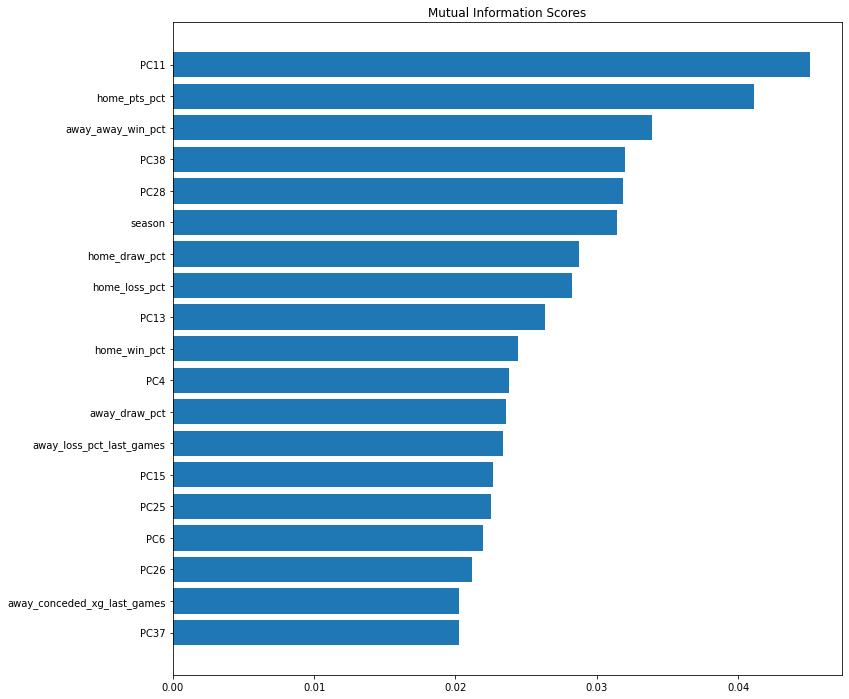

In [12]:
display(X_train)
min_mi_score=0.02
third_mi_scores = pf.make_mi_scores(X_train, y_train)
pf.plot_mi_scores(third_mi_scores[third_mi_scores > min_mi_score])

Results for model naive_bayes:
Classification Report:
              precision    recall  f1-score   support

           A       0.32      0.37      0.34        71
           D       0.32      0.37      0.34        65
           H       0.53      0.44      0.48       131

    accuracy                           0.40       267
   macro avg       0.39      0.39      0.39       267
weighted avg       0.42      0.40      0.41       267

Confusion Matrix:
[[58 33 40]
 [26 24 15]
 [26 19 26]]


Times when H was predicted: 110 (0.41)
Times when D was predicted: 76 (0.28)
Times when A was predicted: 81 (0.3)

Model profit: -260.9999999999999
Maximum negative sequence:  9
Maximum positive sequence:  5
Maximum bet worth: 100.0
Minimum bet worth: 100.0


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,bet_worth,profit,progress
50,H,H,0.068211,0.345870,0.585918,1.70,4.44,3.98,100.0,70.0,2000.0
51,H,A,0.905452,0.042926,0.051622,1.96,3.74,3.48,100.0,-100.0,1970.0
52,H,H,0.024180,0.484051,0.491769,1.69,4.59,3.90,100.0,69.0,2039.0
53,A,H,0.011891,0.181658,0.806451,1.47,6.30,4.49,100.0,-100.0,1939.0
54,H,A,0.558048,0.354907,0.087046,2.29,2.88,3.56,100.0,-100.0,1839.0
...,...,...,...,...,...,...,...,...,...,...,...
312,H,D,0.311550,0.454203,0.234248,1.65,4.55,4.19,100.0,-100.0,1944.0
313,H,D,0.054923,0.495826,0.449251,1.89,3.73,3.74,100.0,-100.0,1844.0
314,A,A,0.488148,0.313038,0.198814,3.28,1.95,4.04,100.0,95.0,1939.0
315,D,H,0.141672,0.412439,0.445889,1.64,4.36,4.38,100.0,-100.0,1839.0


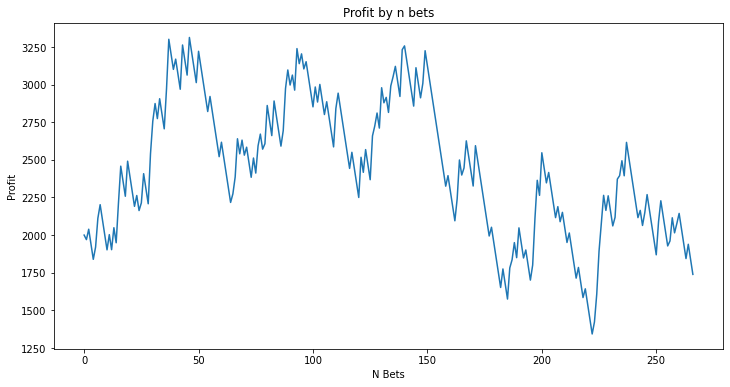

Results for model knn:
Classification Report:
              precision    recall  f1-score   support

           A       0.24      0.17      0.20        71
           D       0.36      0.25      0.29        65
           H       0.48      0.64      0.55       131

    accuracy                           0.42       267
   macro avg       0.36      0.35      0.35       267
weighted avg       0.39      0.42      0.39       267

Confusion Matrix:
[[84 17 30]
 [42 16  7]
 [48 11 12]]


Times when H was predicted: 174 (0.65)
Times when D was predicted: 44 (0.16)
Times when A was predicted: 49 (0.18)

Model profit: -563.0
Maximum negative sequence:  6
Maximum positive sequence:  6
Maximum bet worth: 100.0
Minimum bet worth: 100.0


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,bet_worth,profit,progress
50,H,H,0.0,0.4,0.6,1.70,4.44,3.98,100.0,70.0,2000.0
51,H,A,0.5,0.3,0.2,1.96,3.74,3.48,100.0,-100.0,1970.0
52,H,H,0.2,0.3,0.5,1.69,4.59,3.90,100.0,69.0,2039.0
53,A,H,0.1,0.4,0.5,1.47,6.30,4.49,100.0,-100.0,1939.0
54,H,A,0.4,0.4,0.2,2.29,2.88,3.56,100.0,-100.0,1839.0
...,...,...,...,...,...,...,...,...,...,...,...
312,H,H,0.3,0.1,0.6,1.65,4.55,4.19,100.0,65.0,1664.0
313,H,D,0.3,0.5,0.2,1.89,3.73,3.74,100.0,-100.0,1564.0
314,A,H,0.3,0.2,0.5,3.28,1.95,4.04,100.0,-100.0,1464.0
315,D,H,0.2,0.2,0.6,1.64,4.36,4.38,100.0,-100.0,1364.0


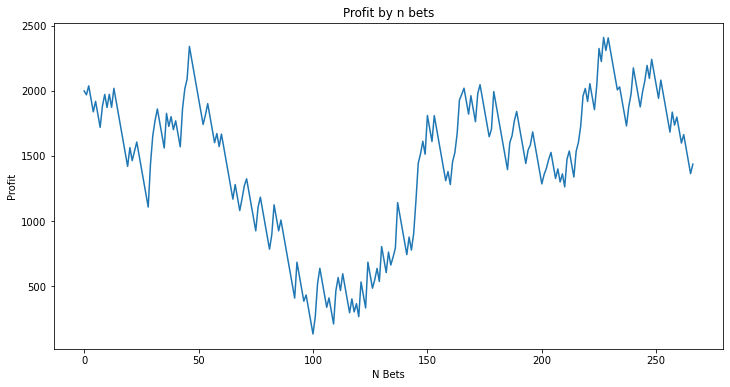

Results for model logistic_regression:
Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.14      0.22        71
           D       0.00      0.00      0.00        65
           H       0.50      0.95      0.66       131

    accuracy                           0.50       267
   macro avg       0.33      0.36      0.29       267
weighted avg       0.38      0.50      0.38       267

Confusion Matrix:
[[124   0   7]
 [ 62   0   3]
 [ 61   0  10]]


Times when H was predicted: 247 (0.93)
Times when D was predicted: 0 (0.0)
Times when A was predicted: 20 (0.07)

Model profit: 56.0
Maximum negative sequence:  8
Maximum positive sequence:  7
Maximum bet worth: 100.0
Minimum bet worth: 100.0


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,bet_worth,profit,progress
50,H,H,0.180833,0.259636,0.559531,1.70,4.44,3.98,100.0,70.0,2000.0
51,H,H,0.402159,0.171773,0.426068,1.96,3.74,3.48,100.0,96.0,2166.0
52,H,H,0.163634,0.265561,0.570805,1.69,4.59,3.90,100.0,69.0,2235.0
53,A,H,0.184068,0.228275,0.587656,1.47,6.30,4.49,100.0,-100.0,2135.0
54,H,H,0.252327,0.335645,0.412028,2.29,2.88,3.56,100.0,129.0,2264.0
...,...,...,...,...,...,...,...,...,...,...,...
312,H,H,0.238786,0.264992,0.496223,1.65,4.55,4.19,100.0,65.0,2094.0
313,H,H,0.159957,0.343102,0.496941,1.89,3.73,3.74,100.0,89.0,2183.0
314,A,H,0.328886,0.252673,0.418441,3.28,1.95,4.04,100.0,-100.0,2083.0
315,D,H,0.223823,0.241166,0.535011,1.64,4.36,4.38,100.0,-100.0,1983.0


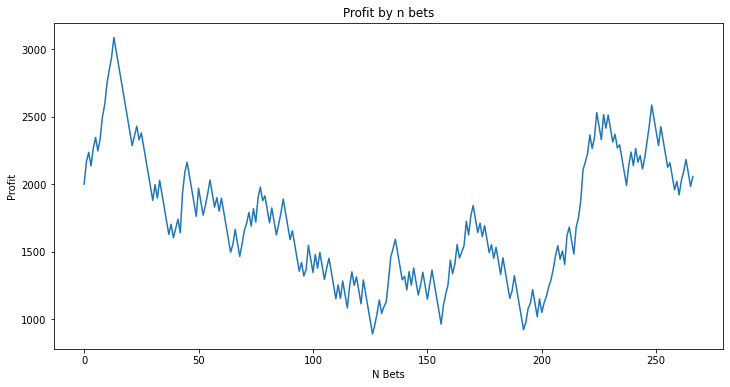

Results for model voting_classifier:
Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.32      0.35        71
           D       0.43      0.18      0.26        65
           H       0.52      0.71      0.60       131

    accuracy                           0.48       267
   macro avg       0.45      0.41      0.40       267
weighted avg       0.46      0.48      0.45       267

Confusion Matrix:
[[93 11 27]
 [44 12  9]
 [43  5 23]]


Times when H was predicted: 180 (0.67)
Times when D was predicted: 28 (0.1)
Times when A was predicted: 59 (0.22)

Model profit: 1561.0
Maximum negative sequence:  8
Maximum positive sequence:  7
Maximum bet worth: 100.0
Minimum bet worth: 100.0


,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,bet_worth,profit,progress
50,H,H,0.083015,0.335169,0.581817,1.70,4.44,3.98,100.0,70.0,2000.0
51,H,A,0.602537,0.171566,0.225897,1.96,3.74,3.48,100.0,-100.0,1970.0
52,H,H,0.129271,0.349871,0.520858,1.69,4.59,3.90,100.0,69.0,2039.0
53,A,H,0.098653,0.269978,0.631369,1.47,6.30,4.49,100.0,-100.0,1939.0
54,H,A,0.403458,0.363517,0.233025,2.29,2.88,3.56,100.0,-100.0,1839.0
...,...,...,...,...,...,...,...,...,...,...,...
312,H,H,0.283445,0.273065,0.443490,1.65,4.55,4.19,100.0,65.0,3788.0
313,H,D,0.171627,0.446309,0.382064,1.89,3.73,3.74,100.0,-100.0,3688.0
314,A,H,0.372345,0.255237,0.372418,3.28,1.95,4.04,100.0,-100.0,3588.0
315,D,H,0.188498,0.284535,0.526967,1.64,4.36,4.38,100.0,-100.0,3488.0


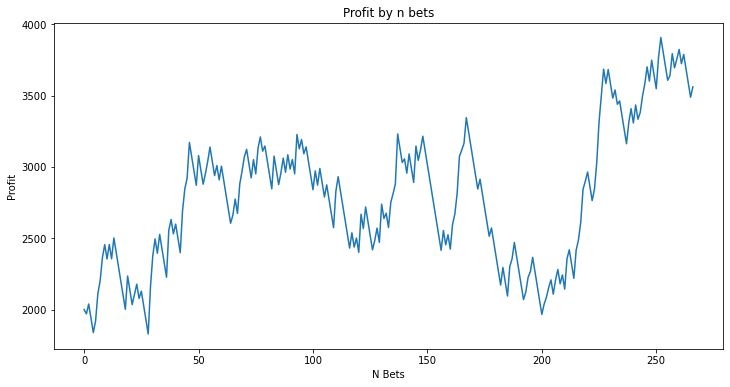

,profit,test_score
naive_bayes,-261.0,0.404494
knn,-563.0,0.419476
logistic_regression,56.0,0.501873
voting_classifier,1561.0,0.479401


,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,bet_worth,profit,progress,won
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.0,267.000000,267.000000,267.000000
mean,0.262722,0.281491,0.455787,2.062097,3.787678,3.824045,100.0,5.846442,2787.857678,0.479401
std,0.141596,0.090452,0.124331,0.487057,1.245288,0.452490,0.0,121.588216,481.903223,0.500514
min,0.047814,0.078758,0.187743,1.230000,1.670000,3.090000,100.0,-100.000000,1829.000000,0.000000
25%,0.145276,0.219022,0.367614,1.710000,2.895000,3.540000,100.0,-100.000000,2415.500000,0.000000
50%,0.231097,0.269978,0.450749,1.960000,3.590000,3.720000,100.0,-100.000000,2815.000000,0.000000
75%,0.351080,0.336001,0.531370,2.310000,4.420000,4.025000,100.0,93.500000,3082.000000,1.000000
max,0.656039,0.554701,0.814246,4.520000,9.830000,6.630000,100.0,350.000000,3907.000000,1.000000


In [14]:
pipeline = pf.simulate(X_train, y_train, X_test, y_test, odds_test, betting_starts_after_n_games, verbose=2)